In [3]:
#%%capture
%load_ext line_profiler
%matplotlib inline


# Had to install this funcy dependency manually, there was a bug in cadCAD, where the dependency wasn't loaded
# import sys
# !{sys.executable} -m pip install --user funcy

# instal line profiler, for optimizing notebook
# !pip install --user line_profiler

import matplotlib.pyplot as plt
import pandas as pd
import math
import importlib
import policies
import config
import state_updates
import utils
from numpy.random import rand

importlib.reload(config)
importlib.reload(policies)
importlib.reload(state_updates)
importlib.reload(utils)

initial_conditions, rarity, market_settings = config.initial_conditions, config.rarity, config.market_settings

SyntaxError: invalid syntax (policies.py, line 116)

In [3]:
%%time

num_runs = 1

def player_active():
    awake_likelihood = 0.6  # 60% probability of player being awake
    active_likelihood = 0.3 # 30% probability of being active, given they are awake
    return rand() < (awake_likelihood*active_likelihood)

params = {
    'duration': 60, # duration of timestep (in minutes)
    'player_active': player_active
}

simulation_parameters = {
    'T': range(120),
    'N': num_runs,
    'M': params
}

initialized_conditions = utils.initialize(market_settings, initial_conditions)



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'playerPolicy': policies.player_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            'network': state_updates.update_network,
            'bc-totalSupply': state_updates.bc_totalSupply,
            'symmetries': state_updates.update_symmetries,
            #'bc-balance': state_updates.bc_balance,
        }
    }
]

# partial_state_update_blockzzzs = [
#     miner_interactions, # miners who only take rewards and run at defined hashrates
#     player_interactions, # players who are sporadically playing, low hash rates, probabilistic buy/sell
#     market_interactions, # players who buy / sell clovers from market
#     speculators # folks speculating on clovercoin price
# ]

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



from cadCAD.configuration import Configuration
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initialized_conditions.copy(), #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD import configs

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

single_proc: [<cadCAD.configuration.Configuration object at 0x7f794e891dd8>]
CPU times: user 11.5 s, sys: 230 ms, total: 11.7 s
Wall time: 11.8 s


In [4]:
%%time

def to_df(raw_result):
    def flatten_cols(row):
        g = row['network']
        new_cols = {}

        
        players = utils.get_nodes_by_type(g, 'player')
        clovers = utils.get_nodes_by_type(g, 'clover')
        
        new_cols['players'] = len(players)
        new_cols['clovers'] = len(clovers)
        new_cols['bankClovers'] = len([x for x in clovers if utils.owner_type(g, x) == 'bank'])
        new_cols.update(row['symmetries'])
        # new_cols['playerClovers'] = new_cols['clovers'] = new_cols['bankClovers']
        # for clover_attr in ['hasSymmetry', 'y0Sym', 'x0Sym', 'xySym', 'xnySym', 'rotSym', 'pretty']:
        #     new_cols['net_' + clover_attr] = len([c for c in clovers if g.nodes[c][clover_attr]])

        res = {**row, **new_cols}
        res.pop('network')
        res.pop('symmetries')
        return res

    return pd.DataFrame(map(flatten_cols, raw_result))

df = to_df(raw_result)

# adding new useful columns for graphing
df['coin-price'] = utils.calculateCurrentPrice(
    (df['bc-totalSupply'] + market_settings['bc-virtualSupply']),
    (df['bc-balance'] + market_settings['bc-virtualBalance']),
    market_settings['bc-reserveRatio'])

df

CPU times: user 497 ms, sys: 3.83 ms, total: 501 ms
Wall time: 506 ms


In [5]:
df

,bankClovers,bc-balance,bc-totalSupply,clovers,hasSymmetry,players,rotSym,run,substep,timestep,x0Sym,xnySym,xySym,y0Sym,coin-price
0,0,40,30297.222283,0,0,20,0,1,0,0,0,0,0,0,0.001681
1,17,40,30359.372283,23,23,20,0,1,1,1,1,9,9,4,0.001680
2,30,40,30453.772283,41,41,20,0,1,1,2,2,15,18,6,0.001679
3,39,40,30527.872283,53,53,20,0,1,1,3,3,22,22,6,0.001678
4,55,40,30743.672283,76,76,20,0,1,1,4,7,29,32,8,0.001675
5,62,40,30959.222283,88,88,20,0,1,1,5,8,35,35,10,0.001672
6,79,40,31210.572283,111,111,20,1,1,1,6,9,44,44,13,0.001669
7,96,40,31379.372283,132,132,20,1,1,1,7,13,51,52,15,0.001667
8,106,40,31322.872283,143,143,20,1,1,1,8,14,54,58,15,0.001668
9,119,40,31555.922283,160,160,20,1,1,1,9,15,62,63,18,0.001665


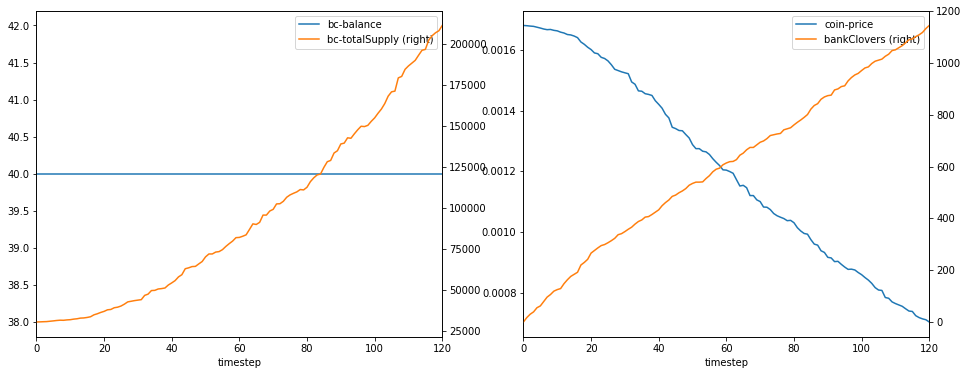

In [8]:
fig = plt.figure(figsize=(16,6*num_runs))
axs = fig.subplots(num_runs, 2)

if num_runs == 1:
    df[df.run == (run+1)].plot('timestep', ['bc-balance', 'bc-totalSupply'], secondary_y=['bc-totalSupply'], ax=axs[0])
    df[df.run == (run+1)].plot('timestep', ['coin-price', 'bankClovers'], secondary_y=['bankClovers'], ax=axs[1])
else:
    for run in range(0,num_runs):
        df[df.run == (run+1)].plot('timestep', ['bc-balance', 'bc-totalSupply'], secondary_y=['bc-totalSupply'], ax=axs[run,0])
        df[df.run == (run+1)].plot('timestep', ['coin-price', 'bankClovers'], secondary_y=['bankClovers'], ax=axs[run,1])

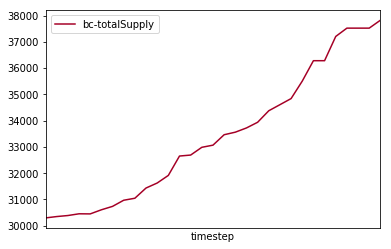

In [33]:
df_run = df[df.run == 1]
df_run.plot('timestep', ['bc-totalSupply'], grid=False, 
        xticks=[], 
        colormap = 'RdYlGn',
       )

In [10]:
for i in range(5):
    print(1)

1
1
1
1
1


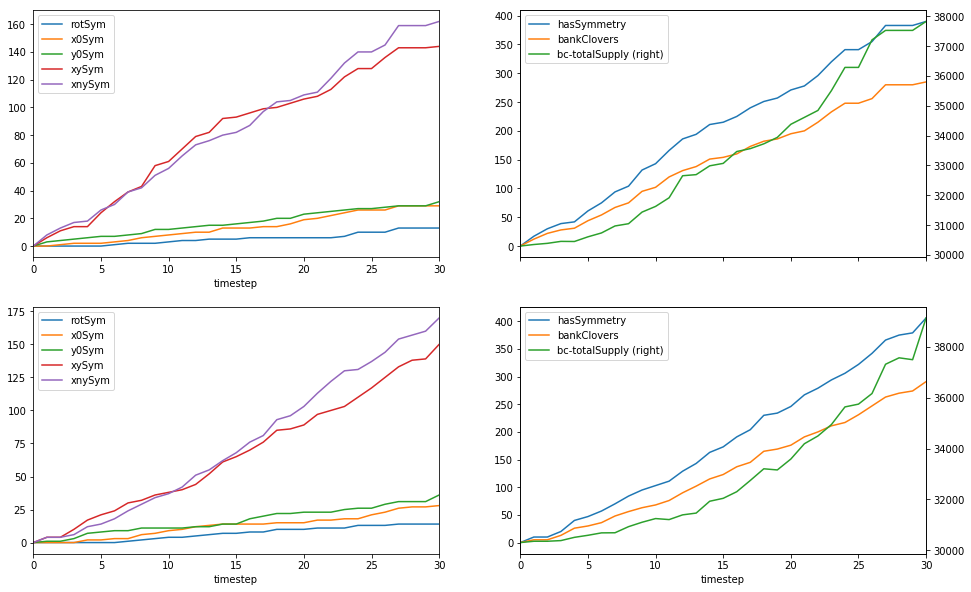

In [34]:
row_height = 5
# set a figure with initial dimensions
fig = plt.figure(figsize=(16,(row_height*num_runs)))

# create 2 axes (2 graphs) laid out in a 1x2 grid, and set them each to a variable
axs = fig.subplots(num_runs, 2)

for row_idx in range(0,num_runs):
    df_run = df[df.run == (row_idx + 1)]
    # draw out all the symmetries in a single graph, on ax1 (the left graph)
    df_run.plot('timestep', ['rotSym', 'x0Sym', 'y0Sym', 'xySym', 'xnySym'], grid=False, 
            ax=axs[row_idx,0]
           )
    
    # draw out the bank clovers and total symms on ax2 (the right graph)
    df_run.plot('timestep', ['hasSymmetry','bankClovers'], ax=axs[row_idx,1])
    
    # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
    df_run.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[row_idx,1])

In [2]:
g = raw_result[60]['network']

clovers = utils.get_nodes_by_type(g, 'clover')

g.nodes[clovers[5]]

p = g.nodes[5]

NameError: name 'raw_result' is not defined

In [21]:
p['newField'] = 23

In [22]:
p

{'type': 'player',
 'hashrate': 18.64259841090662,
 'player_active_percent': 0.7,
 'supply': -499.14999999999986,
 'eth-spent': 0,
 'newField': 23}

In [23]:
g.nodes[5]

{'type': 'player',
 'hashrate': 18.64259841090662,
 'player_active_percent': 0.7,
 'supply': -499.14999999999986,
 'eth-spent': 0,
 'newField': 23}

In [7]:
clovers = [{'me': 'you'}, {'me': 'other'}, {'you': 'me'}]

In [8]:
[foo for foo in clovers if foo['me'] == 'you']

KeyError: 'me'

In [10]:
from scipy.stats import norm

norm.interval(0.999)

(-3.2905267314918945, 3.2905267314919255)

NameError: name 'g' is not defined

In [28]:
import networkx as nx
g = nx.DiGraph()

for i in range(5):
    g.add_node(i)
    
    
g.add_edge(1,2)
print("original edges:")
for i in g.edges(1):
    print(i)

ebunch = g.edges(1)
#g.remove_edges_from(g.edges(1))
    
print("new edges:")
for i in g.edges(1):
    print(i)

original edges:
(1, 2)
new edges:
(1, 2)


In [30]:
ebunch = g.edges(1)

g.remove_edges_from(ebunch)